In [160]:
%load_ext autoreload
%autoreload 2

from data_processing.data_loader import *
from data_processing.trade_features import *
from data_processing.ob_features import *
from datetime import datetime, timedelta
import pytz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
folder = "data"
contract = "CAKEUSDT"
start_date = datetime(2025, 4, 1, tzinfo=pytz.UTC)
end_date = datetime(2025, 4, 3, tzinfo=pytz.UTC)

In [ ]:



trades_feature = TradeFeature(1, inc_vwap=True, inc_vwap_change=True, inc_vol=True, inc_vol_change=True, inc_taker_vol=True, inc_taker_vol_change=True)
volatility_feature = VolatilityFeature(10)
ob_feature = LevelOBFeature(num_levels=10, change=False, include_prices=True)


input_feature_creator = FeatureCreator([
    trades_feature, 
    volatility_feature,
    ob_feature,
    MidPriceFeature(0, inc_mp=True)
    ])

output_feature_creator = FeatureCreator([
    MidPriceFeature(10, inc_mp_change=True)

])

dl = DataLoader()

input_features, output_features = dl.load_features_from_data_parallel(
    folder, 
    contract, 
    start_date, 
    end_date, 
    timedelta(seconds=60),
    input_feature_creator, 
    output_feature_creator,
    max_workers=2
    )

In [181]:
input_features, output_features = dl.load_features_from_data_parallel(
    folder, 
    contract, 
    start_date, 
    end_date, 
    timedelta(seconds=60),
    input_feature_creator, 
    output_feature_creator,
    max_workers=3
    )

submitted all data loading jobs
Processing 2025-04-01
Processing 2025-04-02
Processing 2025-04-03


In [179]:
len(input_features)

1430

In [174]:
snapshots[-1]["timestamp"]

datetime.datetime(2025, 4, 2, 0, 0, 0, 27000, tzinfo=<UTC>)

### Training

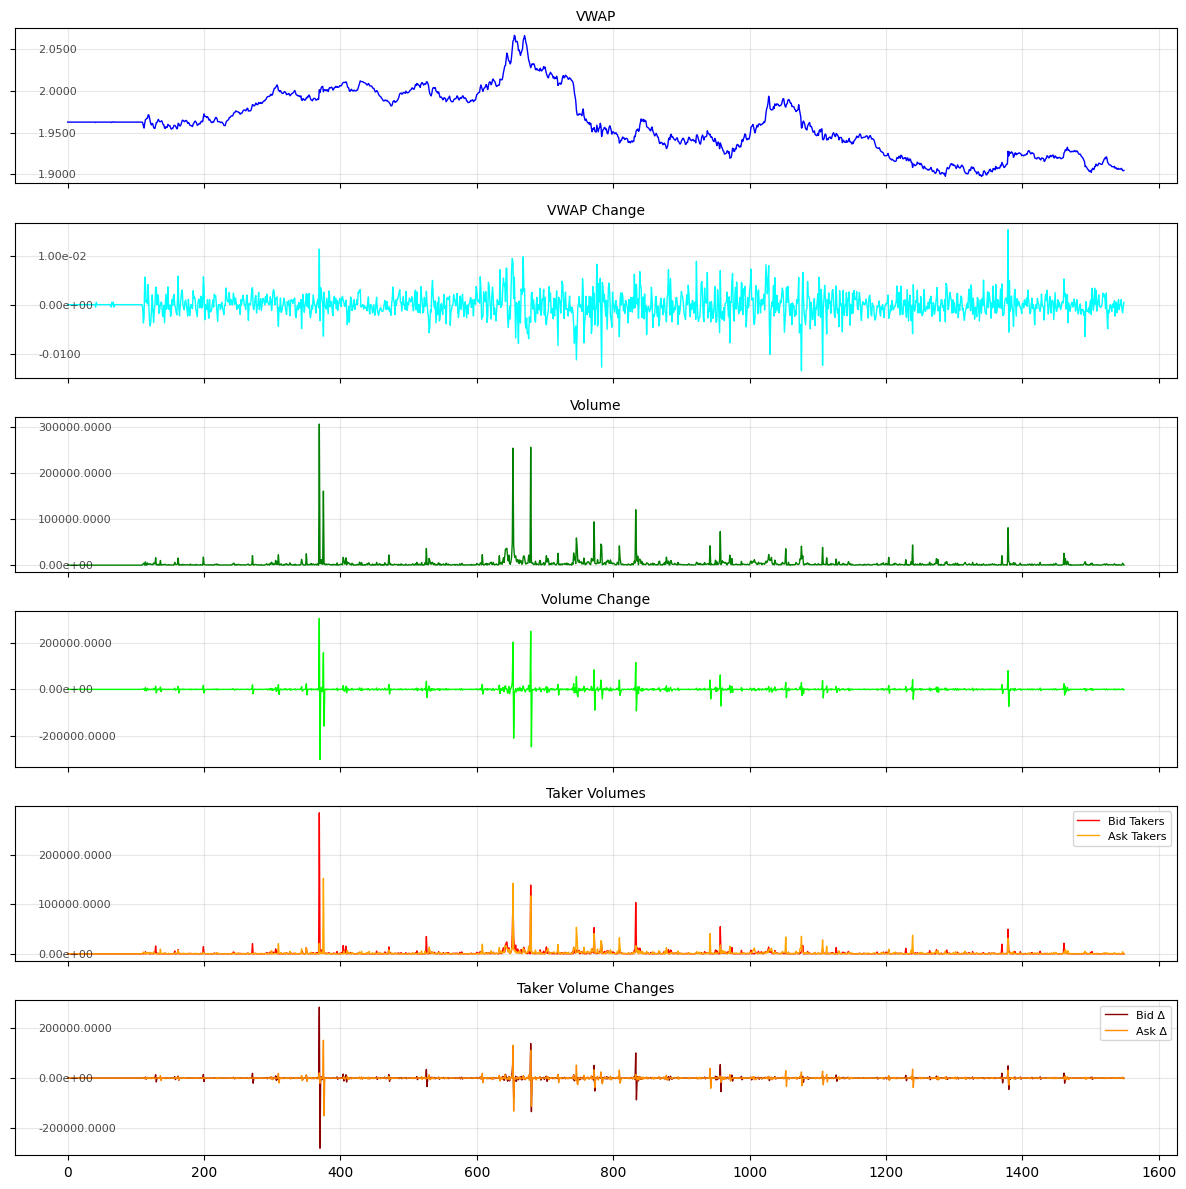

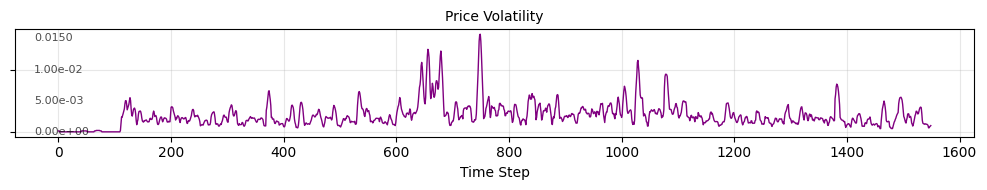

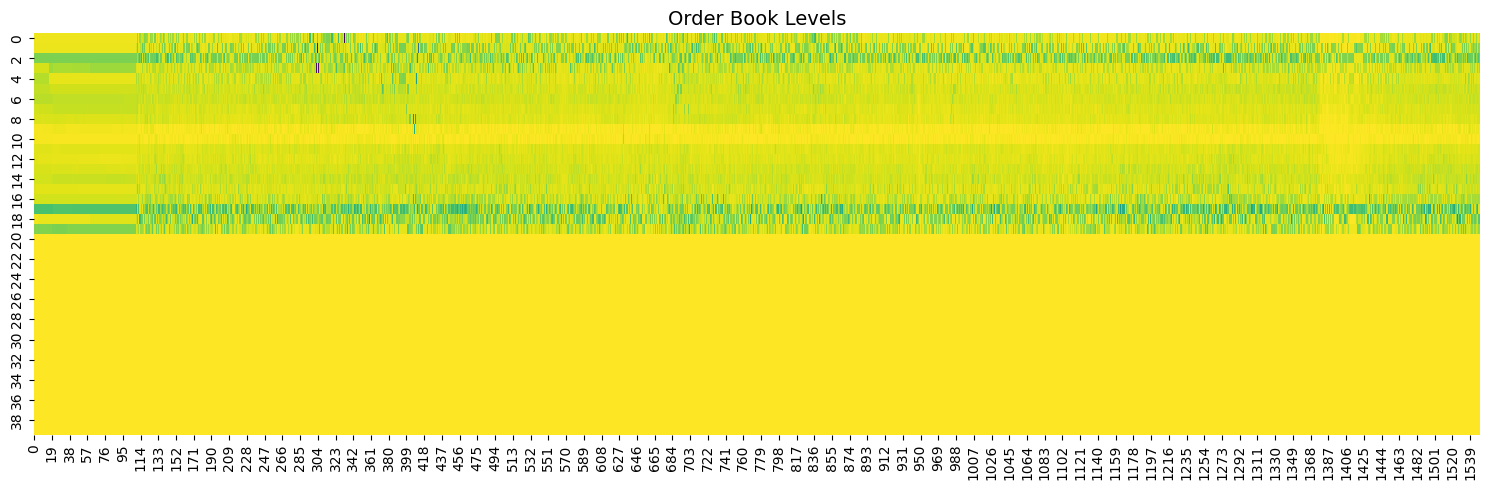

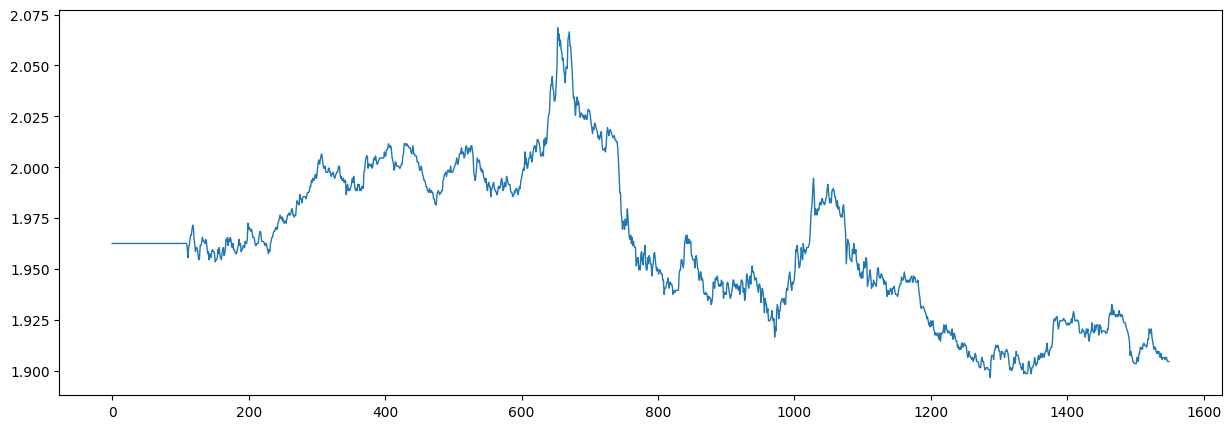

In [100]:
input_feature_creator.visualize(input_features)

Model, feature creator, and description saved to ml_models/CAKEUSDT/time_delta=1000ms/window_length=20/target=scalar/TEST_123


In [101]:
from machine_learning.machine_learning.ml_processing import *

In [102]:
X_data, Y_data = build_data_set_from_features(
        input_features=input_features,
        output_features=output_features, 
        window_len=20,
        horizon=10,
        steps_between=1)

In [103]:
train_split = int(len(X_data) * 0.8)
x_train, y_train = X_data[:train_split], Y_data[:train_split]
x_val, y_val = X_data[train_split:], Y_data[train_split:]

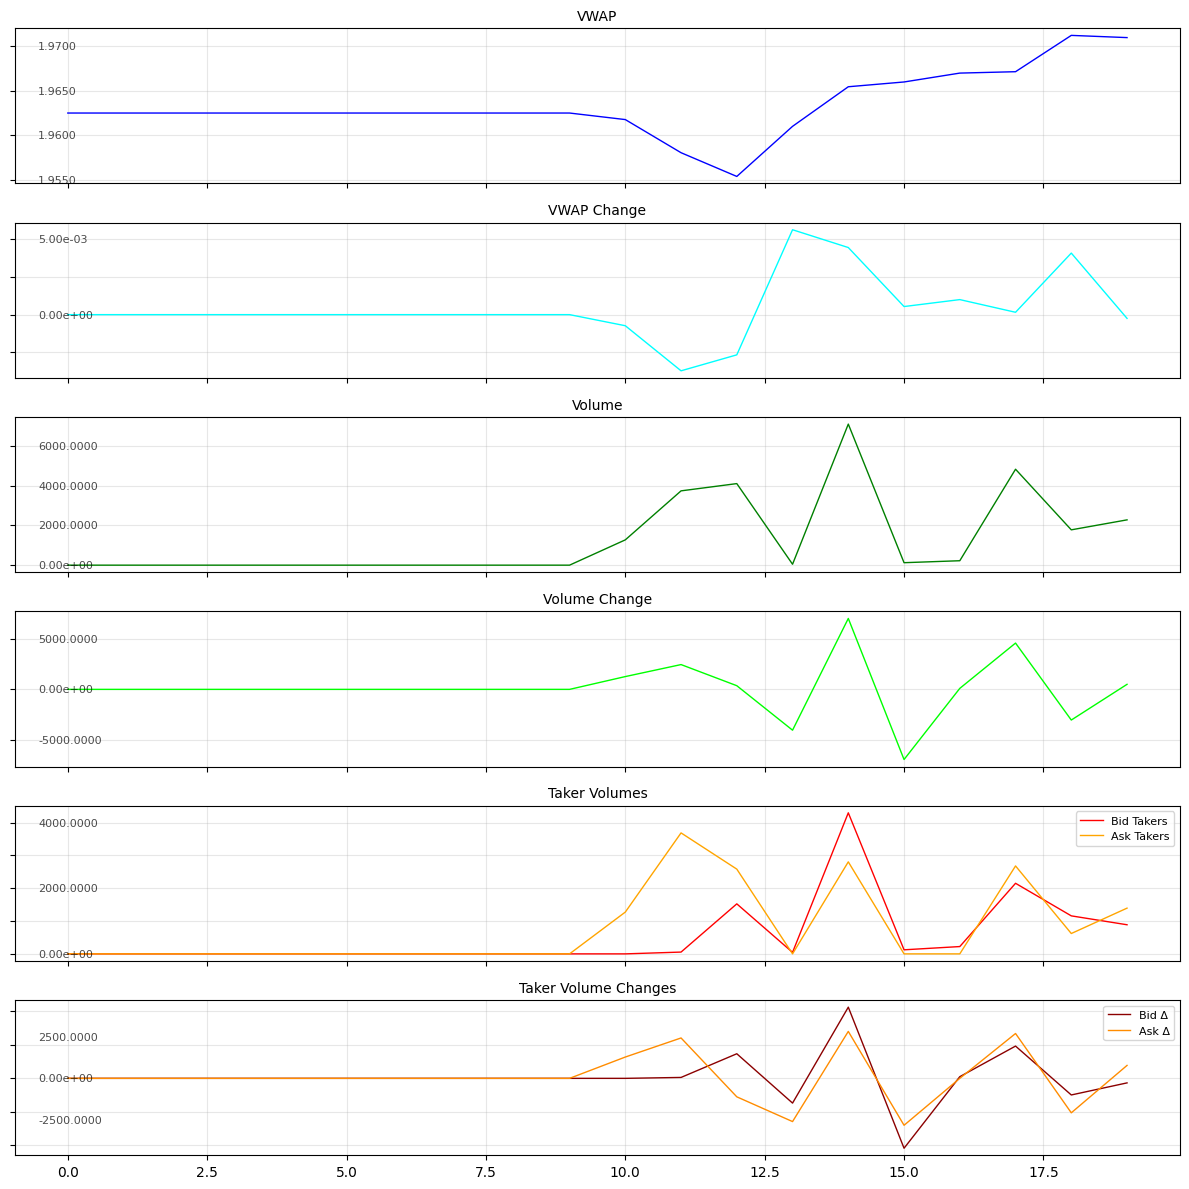

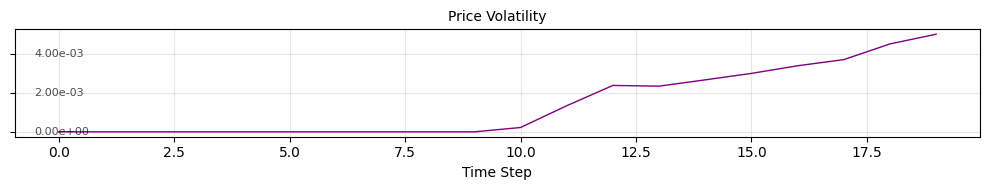

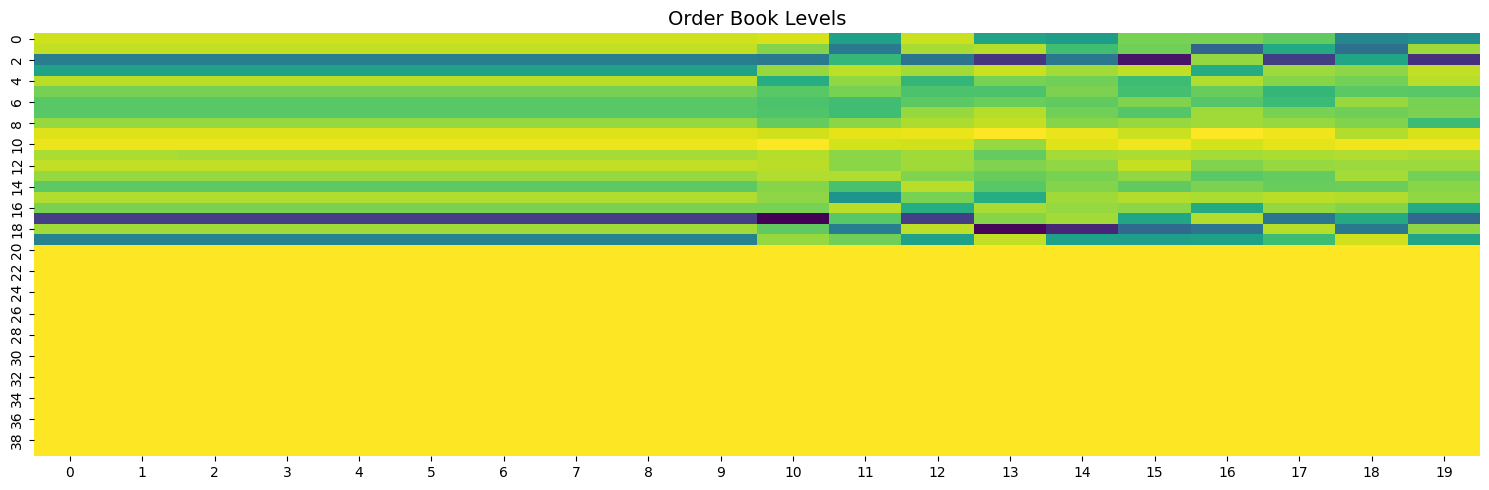

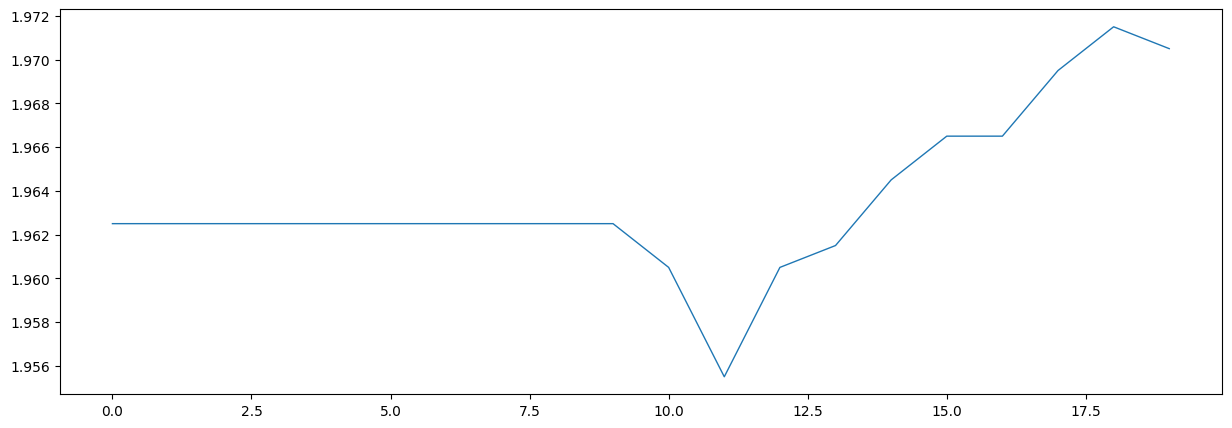

In [104]:
input_feature_creator.visualize(x_train[100])

### Training

In [105]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from machine_learning.machine_learning.transformer_model.model import *
from machine_learning.machine_learning.ml_processing import *
from machine_learning.machine_learning.evaluation import *
from machine_learning.machine_learning.training import *

In [106]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [107]:
dataset_train = TensorDataset(x_train, y_train)
loader_train = DataLoader(dataset_train, batch_size=256, shuffle=True)


dataset_val = TensorDataset(x_val, y_val)
loader_val = DataLoader(dataset_val, batch_size=256, shuffle=True)

In [108]:
base_model = BasicTransformerModel(
    d_model=12,          # Embedding dimension
    nhead=1,             # Number of attention heads
    num_layers=1,        # Number of transformer layers
    output_dim=1,        # Number of output dimensions
    use_softmax=False,
    loss_function="mse" #"mse"  "ce", "mle"
)    # Whether to apply softmax to output

/opt/anaconda3/envs/crypto/lib/python3.9/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/opt/anaconda3/envs/crypto/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [109]:
model = NormalizedModel(
            base_model,
            x_train,
            y_train,
            norm_input_std=True,
            norm_input_mean=True,
            norm_output_std=True,
            norm_output_mean=False)

In [122]:
output = train(model, loader_train, loader_val, epochs=10, lr=0.001, init_params=False, metrics=[trend_accuracy_metric])

Training on: cpu
Epoch 1/10, train loss: 0.0000, val loss 0.0000
TRAIN: Acc=0.743 | 5%=0.981 10%=0.981 15%=0.975 20%=0.954 25%=0.933 
VAL:   Acc=0.502 | 5%=0.357 10%=0.393 15%=0.405 20%=0.411 25%=0.429 
Epoch 2/10, train loss: 0.0000, val loss 0.0000
TRAIN: Acc=0.753 | 5%=1.000 10%=0.981 15%=0.969 20%=0.963 25%=0.937 
VAL:   Acc=0.466 | 5%=0.357 10%=0.321 15%=0.357 20%=0.393 25%=0.429 
Epoch 3/10, train loss: 0.0000, val loss 0.0000
TRAIN: Acc=0.749 | 5%=1.000 10%=0.972 15%=0.957 20%=0.954 25%=0.933 
VAL:   Acc=0.448 | 5%=0.500 10%=0.429 15%=0.476 20%=0.429 25%=0.386 
Epoch 4/10, train loss: 0.0000, val loss 0.0000
TRAIN: Acc=0.754 | 5%=1.000 10%=0.981 15%=0.963 20%=0.958 25%=0.944 
VAL:   Acc=0.456 | 5%=0.214 10%=0.357 15%=0.429 20%=0.411 25%=0.400 
Epoch 5/10, train loss: 0.0000, val loss 0.0000
TRAIN: Acc=0.748 | 5%=1.000 10%=0.991 15%=0.969 20%=0.963 25%=0.952 
VAL:   Acc=0.456 | 5%=0.357 10%=0.500 15%=0.452 20%=0.464 25%=0.457 
Epoch 6/10, train loss: 0.0000, val loss 0.0000
TRAIN

In [123]:
input_feature_creator.get_feature(x_val[0], 3)

tensor([[1.9175],
        [1.9185],
        [1.9185],
        [1.9195],
        [1.9225],
        [1.9185],
        [1.9205],
        [1.9225],
        [1.9205],
        [1.9195],
        [1.9185],
        [1.9195],
        [1.9195],
        [1.9185],
        [1.9175],
        [1.9175],
        [1.9205],
        [1.9155],
        [1.9155],
        [1.9185]])

In [124]:
y_val[0]

tensor([-0.0080])

In [130]:
input_feature_creator.get_feature(x_val[15], 3)

tensor([[1.9175],
        [1.9205],
        [1.9155],
        [1.9155],
        [1.9185],
        [1.9175],
        [1.9155],
        [1.9145],
        [1.9145],
        [1.9115],
        [1.9125],
        [1.9105],
        [1.9105],
        [1.9115],
        [1.9105],
        [1.9135],
        [1.9135],
        [1.9115],
        [1.9125],
        [1.9135]])

In [131]:
1.9105 - 1.9185

-0.008000000000000007

In [132]:
print("------------- Validation Data -------------")
evaluate_mse_prediction(y_val_pred, y_val)

------------- Validation Data -------------


NameError: name 'y_val_pred' is not defined

------------- TRAINING DATA -------------

Confusion Matrix (% of Total Samples):
┌────────────┬─────────────────┬─────────────────┬─────────────┐
│            │ Predicted Down  │  Predicted Up   │    Total    │
├────────────┼─────────────────┼─────────────────┼───────── ───┤
│ Actual Down│      22.1%      │      27.4%      │    49.5%    │
├────────────┼─────────────────┼─────────────────┼─────────────┤
│ Actual Up  │      22.2%      │      28.3%      │    50.5%    │
├────────────┼─────────────────┼─────────────────┼─────────────┤
│ Total      │      44.3%      │      55.7%      │   100.0%    │
└────────────┴─────────────────┴─────────────────┴─────────────┘

Overall accuracy: 50.4%

Trend Prediction:
Correct trends: 3245/6436 (50.42%)
Up trend accuracy:   56.03%
Down trend accuracy: 44.69%


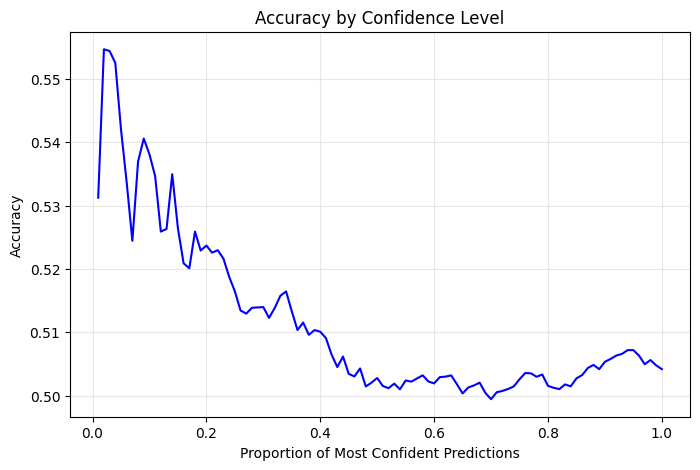

------------- Validation Data -------------

Confusion Matrix (% of Total Samples):
┌────────────┬─────────────────┬─────────────────┬─────────────┐
│            │ Predicted Down  │  Predicted Up   │    Total    │
├────────────┼─────────────────┼─────────────────┼───────── ───┤
│ Actual Down│      22.4%      │      27.6%      │    50.1%    │
├────────────┼─────────────────┼─────────────────┼─────────────┤
│ Actual Up  │      23.9%      │      26.0%      │    49.9%    │
├────────────┼─────────────────┼─────────────────┼─────────────┤
│ Total      │      46.3%      │      53.7%      │   100.0%    │
└────────────┴─────────────────┴─────────────────┴─────────────┘

Overall accuracy: 48.5%

Trend Prediction:
Correct trends: 698/1440 (48.47%)
Up trend accuracy:   52.16%
Down trend accuracy: 44.80%


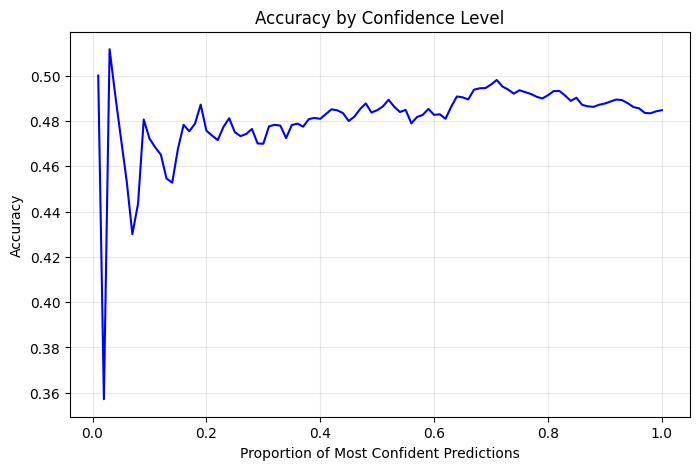

In [ ]:
from ml_models.ml_models.ml import *

print("------------- TRAINING DATA -------------")
evaluate_mse_prediction(y_train_pred, y_train)




------------- Validation Data -------------

Confusion Matrix (% of Total Samples):
┌────────────┬─────────────────┬─────────────────┬─────────────┐
│            │ Predicted Down  │  Predicted Up   │    Total    │
├────────────┼─────────────────┼─────────────────┼───────── ───┤
│ Actual Down│      24.0%      │      30.8%      │    54.8%    │
├────────────┼─────────────────┼─────────────────┼─────────────┤
│ Actual Up  │      23.1%      │      22.1%      │    45.2%    │
├────────────┼─────────────────┼─────────────────┼─────────────┤
│ Total      │      47.1%      │      52.9%      │   100.0%    │
└────────────┴─────────────────┴─────────────────┴─────────────┘

Overall accuracy: 46.2%

Trend Prediction:
Correct trends: 48/104 (46.15%)
Up trend accuracy:   48.94%
Down trend accuracy: 43.86%


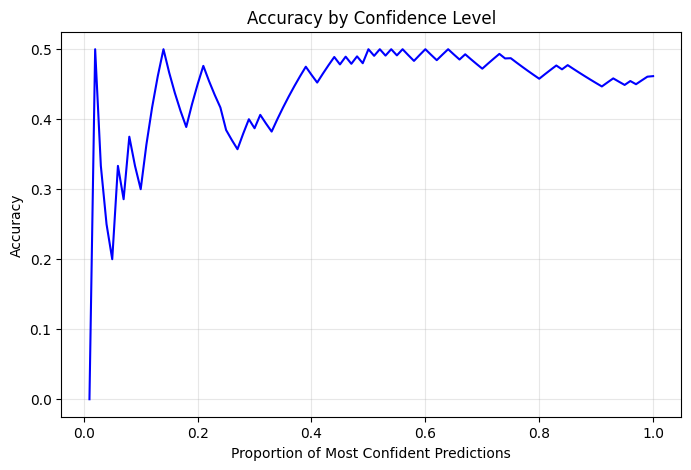

In [121]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, accuracy_score

def evaluate_mle_prediction(prediction, targets):
    if torch.is_tensor(prediction):
        prediction = prediction.detach().cpu().numpy()
    if torch.is_tensor(targets):
        targets = targets.detach().cpu().numpy()
    
    # Handle different shapes of prediction
    if len(prediction.shape) == 1:
        # If prediction is 1D, reshape it to 2D for a single output
        means = prediction
        variances = np.ones_like(means) * 0.01  # Default variance if not provided
    else:
        # Standard case with [batch_size, 2] output
        means = prediction[:, 0]
        variances = prediction[:, 1] if prediction.shape[1] > 1 else np.ones_like(means) * 0.01
    
    # Make sure targets is 1D
    if len(targets.shape) > 1:
        targets = targets.flatten()
    
    # Filter out instances where price change is zero
    non_zero_indices = targets != 0
    filtered_means = means[non_zero_indices]
    filtered_variances = variances[non_zero_indices]
    filtered_targets = targets[non_zero_indices]
    
    # Binary classification: 0 = down, 1 = up
    pred_classes = (filtered_means > 0).astype(int)
    target_classes = (filtered_targets > 0).astype(int)
    
    acc = accuracy_score(target_classes, pred_classes)
    cm = confusion_matrix(target_classes, pred_classes)
    
    total = cm.sum()
    cm_percentage = (cm / total * 100)
    cm_percentage = np.round(cm_percentage).astype(int)
    
    print(f"Accuracy: {int(acc*100)}%")
    print(f"Total non-zero samples evaluated: {len(filtered_targets)}")
    print("\nConfusion Matrix (percentages):")
    print(f"{'':10s} | {'Predictions':^20s} | {'':5s}")
    print(f"{'Truth':10s} | {'Down':^8s} | {'Up':^8s} | {'Sum':^5s}")
    print("-" * 37)
    
    row_sums = cm_percentage.sum(axis=1)
    col_sums = cm_percentage.sum(axis=0)
    
    class_names = ["Down", "Up"]
    for i in range(cm_percentage.shape[0]):
        print(f"{class_names[i]:10s} | {cm_percentage[i,0]:8d} | {cm_percentage[i,1]:8d} | {row_sums[i]:5d}")
        print("-" * 37)
    
    print(f"{'Sum':10s} | {col_sums[0]:8d} | {col_sums[1]:8d} | {cm_percentage.sum():5d}")
    
    avg_variance = np.mean(filtered_variances)
    print(f"\nAverage prediction variance: {avg_variance:.4f}")
    
    variance_by_class = []
    for i in range(2):
        class_indices = np.where(target_classes == i)[0]
        if len(class_indices) > 0:
            class_var = np.mean(filtered_variances[class_indices])
            variance_by_class.append(class_var)
        else:
            variance_by_class.append(0)
    
    print("\nAverage variance by true class:")
    for i, var in enumerate(variance_by_class):
        print(f"Class {class_names[i]}: {var:.4f}")
    
    correct_indices = np.where(pred_classes == target_classes)[0]
    incorrect_indices = np.where(pred_classes != target_classes)[0]
    
    if len(correct_indices) > 0:
        correct_var = np.mean(filtered_variances[correct_indices])
        print(f"\nAverage variance for correct predictions: {correct_var:.4f}")
    
    if len(incorrect_indices) > 0:
        incorrect_var = np.mean(filtered_variances[incorrect_indices])
        print(f"Average variance for incorrect predictions: {incorrect_var:.4f}")
    
    return acc

In [15]:
def evaluate_softmax_prediction(prediction, targets):
    """
    Evaluate softmax predictions and display percentage-based confusion matrix
    """
    import numpy as np
    import torch
    from sklearn.metrics import confusion_matrix, accuracy_score
    
    # Detach tensors from computation graph and convert to numpy
    if torch.is_tensor(prediction):
        prediction = prediction.detach().cpu().numpy()
    if torch.is_tensor(targets):
        targets = targets.detach().cpu().numpy()
    
    # Convert both predictions and targets to class indices
    pred_classes = np.argmax(prediction, axis=1)
    target_classes = np.argmax(targets, axis=1)
    
    # Calculate accuracy
    acc = accuracy_score(target_classes, pred_classes)
    
    # Get confusion matrix
    cm = confusion_matrix(target_classes, pred_classes)
    
    # Normalize by total count to make all cells sum to 100%
    total = cm.sum()
    cm_percentage = (cm / total * 100)
    
    # Round to integers to remove decimal places
    cm_percentage = np.round(cm_percentage).astype(int)
    
    # Print results
    print(f"Accuracy: {int(acc*100)}%")
    print("\nConfusion Matrix (percentages):")
    
    # Print header (prediction labels)
    print(f"{'':10s} | {'Predictions':^30s} | {'':5s}")
    print(f"{'Truth':10s} | {'0':^8s} | {'1':^8s} | {'2':^8s} | {'Sum':^5s}")
    print("-" * 47)
    
    # Print matrix with row and column sums
    row_sums = cm_percentage.sum(axis=1)
    col_sums = cm_percentage.sum(axis=0)
    
    for i in range(cm_percentage.shape[0]):
        print(f"{i:10d} | {cm_percentage[i,0]:8d} | {cm_percentage[i,1]:8d} | {cm_percentage[i,2]:8d} | {row_sums[i]:5d}")
    
    print("-" * 47)
    print(f"{'Sum':10s} | {col_sums[0]:8d} | {col_sums[1]:8d} | {col_sums[2]:8d} | {cm_percentage.sum():5d}")
    
    return acc

In [71]:
from ml_models.ml_models.transformer_model.model import SimpleOrderBookModel
import torch as pt

# Create model
model = SimpleOrderBookModel(
    hidden_dim=128,
    output_dim=3,             # 3 classes for classification
    use_softmax=True          # Classification task
)

# Train model (replace with your actual data)
trained_model = train_simple(model, x_train, y_train, epochs=20)

# Make predictions
predictions = trained_model(pt.tensor(x_val, dtype=torch.float32))

/opt/anaconda3/envs/trading/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


TypeError: 'int' object is not callable